<a href="https://colab.research.google.com/github/jjandnn/APDrawingGAN2/blob/master/APDrawingGAN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# APDrawingGAN2
[APDrawingGAN的在线网站](https://face.lol)

[项目 Github 地址](https://github.com/yiranran/APDrawingGAN2)
作者：yiranran

Colab：jjandnn

# 安装

In [0]:
from google.colab import drive
drive.mount('/content/drive')
!rm -rf sample_data

#################################################################

# 第一次安装需要，之后使用请注释掉本 # 号栏中的内容
%cd /content/drive/My\ Drive
# 下载整个项目、模型和数据集 打包放在谷歌云盘
!unzip APDrawingGAN2.zip
!rm -rf /content/drive/My\ Drive/APDrawingGAN2.zip
!wget https://nchc.dl.sourceforge.net/project/octave/Octave%20Forge%20Packages/Individual%20Package%20Releases/image-2.12.0.tar.gz
%cd /content/drive/My\ Drive/APDrawingGAN2
!mkdir -p preprocess/input_img
!mkdir -p preprocess/results512
!touch preprocess/preprocess_all.py
!touch preprocess/img_preprocess.m

#################################################################

# 日常运行，每次开机都要安装的依赖
%cd /content/drive/My\ Drive/APDrawingGAN2
!apt install octave
!apt install liboctave-dev
!octave --eval "pkg install image-2.12.0.tar.gz"
!pip install dominate visdom

### 改写部分文件(首次安装需要运行)

In [12]:
%cd /content/drive/My Drive/APDrawingGAN2

/content/drive/My Drive/APDrawingGAN2


In [0]:
#@title 修改 util/visualizer.py 适配 scipy 的colab 新版
%%writefile util/visualizer.py
import numpy as np
import os
import ntpath
import time
from . import util
from . import html
from PIL import Image


# save image to the disk
def save_images(webpage, visuals, image_path, aspect_ratio=1.0, width=256):
    image_dir = webpage.get_image_dir()
    short_path = ntpath.basename(image_path[0])
    name = os.path.splitext(short_path)[0]

    webpage.add_header(name)
    ims, txts, links = [], [], []

    for label, im_data in visuals.items():
        im = util.tensor2im(im_data) #tensor to numpy array [-1,1]->[0,1]->[0,255]
        image_name = '%s_%s.png' % (name, label)
        save_path = os.path.join(image_dir, image_name)
        h, w, _ = im.shape
        if aspect_ratio > 1.0:
            # im = imresize(im, (h, int(w * aspect_ratio)), interp='bicubic')
            im = np.array(Image.fromarray(im).resize((h, int(w * aspect_ratio))))

        if aspect_ratio < 1.0:
            # im = imresize(im, (int(h / aspect_ratio), w), interp='bicubic')
            im = np.array(Image.fromarray(im).resize((int(h / aspect_ratio), w)))
        util.save_image(im, save_path)

        ims.append(image_name)
        txts.append(label)
        links.append(image_name)
    webpage.add_images(ims, txts, links, width=width)


class Visualizer():
    def __init__(self, opt):
        self.display_id = opt.display_id
        self.use_html = opt.isTrain and not opt.no_html
        self.win_size = opt.display_winsize
        self.name = opt.name
        self.opt = opt
        self.saved = False
        if self.display_id > 0:
            import visdom
            self.ncols = opt.display_ncols
            self.vis = visdom.Visdom(server=opt.display_server, port=opt.display_port, env=opt.display_env, raise_exceptions=True)

        if self.use_html:
            self.web_dir = os.path.join(opt.checkpoints_dir, opt.name, 'web')
            self.img_dir = os.path.join(self.web_dir, 'images')
            print('create web directory %s...' % self.web_dir)
            util.mkdirs([self.web_dir, self.img_dir])
        self.log_name = os.path.join(opt.checkpoints_dir, opt.name, 'loss_log.txt')
        with open(self.log_name, "a") as log_file:
            now = time.strftime("%c")
            log_file.write('================ Training Loss (%s) ================\n' % now)

    def reset(self):
        self.saved = False

    def throw_visdom_connection_error(self):
        print('\n\nCould not connect to Visdom server (https://github.com/facebookresearch/visdom) for displaying training progress.\nYou can suppress connection to Visdom using the option --display_id -1. To install visdom, run \n$ pip install visdom\n, and start the server by \n$ python -m visdom.server.\n\n')
        exit(1)

    # |visuals|: dictionary of images to display or save
    def display_current_results(self, visuals, epoch, save_result):
        if self.display_id > 0:  # show images in the browser
            ncols = self.ncols
            if ncols > 0:
                ncols = min(ncols, len(visuals))
                h, w = next(iter(visuals.values())).shape[:2]
                table_css = """<style>
                        table {border-collapse: separate; border-spacing:4px; white-space:nowrap; text-align:center}
                        table td {width: %dpx; height: %dpx; padding: 4px; outline: 4px solid black}
                        </style>""" % (w, h)
                title = self.name
                label_html = ''
                label_html_row = ''
                images = []
                idx = 0
                for label, image in visuals.items():
                    image_numpy = util.tensor2im(image)
                    label_html_row += '<td>%s</td>' % label
                    images.append(image_numpy.transpose([2, 0, 1]))
                    idx += 1
                    if idx % ncols == 0:
                        label_html += '<tr>%s</tr>' % label_html_row
                        label_html_row = ''
                white_image = np.ones_like(image_numpy.transpose([2, 0, 1])) * 255
                while idx % ncols != 0:
                    images.append(white_image)
                    label_html_row += '<td></td>'
                    idx += 1
                if label_html_row != '':
                    label_html += '<tr>%s</tr>' % label_html_row
                # pane col = image row
                try:
                    self.vis.images(images, nrow=ncols, win=self.display_id + 1,
                                    padding=2, opts=dict(title=title + ' images'))
                    label_html = '<table>%s</table>' % label_html
                    self.vis.text(table_css + label_html, win=self.display_id + 2,
                                  opts=dict(title=title + ' labels'))
                except ConnectionError:
                    self.throw_visdom_connection_error()

            else:
                idx = 1
                for label, image in visuals.items():
                    image_numpy = util.tensor2im(image)
                    self.vis.image(image_numpy.transpose([2, 0, 1]), opts=dict(title=label),
                                   win=self.display_id + idx)
                    idx += 1

        if self.use_html and (save_result or not self.saved):  # save images to a html file
            self.saved = True
            for label, image in visuals.items():
                image_numpy = util.tensor2im(image)
                img_path = os.path.join(self.img_dir, 'epoch%.3d_%s.png' % (epoch, label))
                util.save_image(image_numpy, img_path)
            # update website
            webpage = html.HTML(self.web_dir, 'Experiment name = %s' % self.name, reflesh=1)
            for n in range(epoch, 0, -1):
                webpage.add_header('epoch [%d]' % n)
                ims, txts, links = [], [], []

                for label, image_numpy in visuals.items():
                    image_numpy = util.tensor2im(image)
                    img_path = 'epoch%.3d_%s.png' % (n, label)
                    ims.append(img_path)
                    txts.append(label)
                    links.append(img_path)
                webpage.add_images(ims, txts, links, width=self.win_size)
            webpage.save()
    
    def save_current_results1(self, visuals, epoch, epoch_iter):
        if not os.path.exists(self.img_dir+'/detailed'):
            os.mkdir(self.img_dir+'/detailed')
        for label, image in visuals.items():
            image_numpy = util.tensor2im(image)
            img_path = os.path.join(self.img_dir, 'detailed', 'epoch%.3d_%.3d_%s.png' % (epoch, epoch_iter, label))
            util.save_image(image_numpy, img_path)

    # losses: dictionary of error labels and values
    def plot_current_losses(self, epoch, counter_ratio, opt, losses):
        if not hasattr(self, 'plot_data'):
            self.plot_data = {'X': [], 'Y': [], 'legend': list(losses.keys())}
        self.plot_data['X'].append(epoch + counter_ratio)
        self.plot_data['Y'].append([losses[k] for k in self.plot_data['legend']])
        try:
            self.vis.line(
                X=np.stack([np.array(self.plot_data['X'])] * len(self.plot_data['legend']), 1),
                Y=np.array(self.plot_data['Y']),
                opts={
                    'title': self.name + ' loss over time',
                    'legend': self.plot_data['legend'],
                    'xlabel': 'epoch',
                    'ylabel': 'loss'},
                win=self.display_id)
        except ConnectionError:
            self.throw_visdom_connection_error()

    # losses: same format as |losses| of plot_current_losses
    def print_current_losses(self, epoch, i, losses, t, t_data):
        message = '(epoch: %d, iters: %d, time: %.3f, data: %.3f) ' % (epoch, i, t, t_data)
        for k, v in losses.items():
            message += '%s: %.6f ' % (k, v)

        print(message)
        with open(self.log_name, "a") as log_file:
            log_file.write('%s\n' % message)

Overwriting util/visualizer.py


In [0]:
#@title 修改 data/single_dataset.py 适配 torch、Pillow 的 colab 新版
%%writefile data/single_dataset.py
import os.path
from data.base_dataset import BaseDataset, get_transform
from data.image_folder import make_dataset
from PIL import Image
import numpy as np
import csv
import torch
import torchvision.transforms as transforms

def getfeats(featpath):
	trans_points = np.empty([5,2],dtype=np.int64) 
	with open(featpath, 'r') as csvfile:
		reader = csv.reader(csvfile, delimiter=' ')
		for ind,row in enumerate(reader):
			trans_points[ind,:] = row
	return trans_points

def getSoft(size,xb,yb,boundwidth=5.0):
    xarray = np.tile(np.arange(0,size[1]),(size[0],1))
    yarray = np.tile(np.arange(0,size[0]),(size[1],1)).transpose()
    cxdists = []
    cydists = []
    for i in range(len(xb)):
        xba = np.tile(xb[i],(size[1],1)).transpose()
        yba = np.tile(yb[i],(size[0],1))
        cxdists.append(np.abs(xarray-xba))
        cydists.append(np.abs(yarray-yba))
    xdist = np.minimum.reduce(cxdists)
    ydist = np.minimum.reduce(cydists)
    manhdist = np.minimum.reduce([xdist,ydist])
    im = (manhdist+1) / (boundwidth+1) * 1.0
    im[im>=1.0] = 1.0
    return im

class SingleDataset(BaseDataset):
    @staticmethod
    def modify_commandline_options(parser, is_train):
        return parser

    def initialize(self, opt):
        self.opt = opt
        self.root = opt.dataroot
        self.dir_A = os.path.join(opt.dataroot)
        imglist = 'datasets/apdrawing_list/%s/%s.txt' % (opt.phase, opt.dataroot)
        if os.path.exists(imglist):
            lines = open(imglist, 'r').read().splitlines()
            self.A_paths = sorted(lines)
        else:
            self.A_paths = make_dataset(self.dir_A)
            self.A_paths = sorted(self.A_paths)
        self.transform = get_transform(opt) # this function uses NO_FLIP; aligned dataset do not use this, aligned dataset manually transform

    def __getitem__(self, index):
        A_path = self.A_paths[index]
        A_img = Image.open(A_path).convert('RGB')
        A = self.transform(A_img)
        if self.opt.which_direction == 'BtoA':
            input_nc = self.opt.output_nc
            output_nc = self.opt.input_nc
        else:
            input_nc = self.opt.input_nc
            output_nc = self.opt.output_nc

        if input_nc == 1:  # RGB to gray
            tmp = A[0, ...] * 0.299 + A[1, ...] * 0.587 + A[2, ...] * 0.114
            A = tmp.unsqueeze(0)

        item = {'A': A, 'A_paths': A_path}

        if self.opt.use_local:
            regions = ['eyel','eyer','nose','mouth']
            basen = os.path.basename(A_path)[:-4]+'.txt'
            featdir = self.opt.lm_dir
            featpath = os.path.join(featdir,basen)
            feats = getfeats(featpath)
            mouth_x = int((feats[3,0]+feats[4,0])/2.0)
            mouth_y = int((feats[3,1]+feats[4,1])/2.0)
            ratio = self.opt.fineSize / 256
            EYE_H = self.opt.EYE_H * ratio
            EYE_W = self.opt.EYE_W * ratio
            NOSE_H = self.opt.NOSE_H * ratio
            NOSE_W = self.opt.NOSE_W * ratio
            MOUTH_H = self.opt.MOUTH_H * ratio
            MOUTH_W = self.opt.MOUTH_W * ratio
            center = torch.IntTensor([[feats[0,0],feats[0,1]-4*ratio],[feats[1,0],feats[1,1]-4*ratio],[feats[2,0],feats[2,1]-NOSE_H/2+16*ratio],[mouth_x,mouth_y]])
            item['center'] = center
            rhs = [int(EYE_H),int(EYE_H),int(NOSE_H),int(MOUTH_H)]
            rws = [int(EYE_W),int(EYE_W),int(NOSE_W),int(MOUTH_W)]
            if self.opt.soft_border:
                soft_border_mask4 = []
                for i in range(4):
                    xb = [np.zeros(rhs[i]),np.ones(rhs[i])*(rws[i]-1)]
                    yb = [np.zeros(rws[i]),np.ones(rws[i])*(rhs[i]-1)]
                    soft_border_mask = getSoft([rhs[i],rws[i]],xb,yb)
                    soft_border_mask4.append(torch.Tensor(soft_border_mask).unsqueeze(0))
                    item['soft_'+regions[i]+'_mask'] = soft_border_mask4[i]
            for i in range(4):
                # item[regions[i]+'_A'] = A[:,center[i,1]-rhs[i]/2:center[i,1]+rhs[i]/2,center[i,0]-rws[i]/2:center[i,0]+rws[i]/2] pytorch老版，已经弃用
                item[regions[i]+'_A'] = A[:,int(center[i,1]-rhs[i]/2):int(center[i,1]+rhs[i]/2),int(center[i,0]-rws[i]/2):int(center[i,0]+rws[i]/2)]
                if self.opt.soft_border:
                    item[regions[i]+'_A'] = item[regions[i]+'_A'] * soft_border_mask4[i].repeat(int(input_nc/output_nc),1,1)
            if self.opt.compactmask:
                cmasks0 = []
                cmasks = []
                for i in range(4):
                    cmaskpath = os.path.join(self.opt.cmask_dir,regions[i],basen[:-4]+'.png')
                    im_cmask = Image.open(cmaskpath)
                    cmask0 = transforms.ToTensor()(im_cmask)
                    if output_nc == 1 and cmask0.shape[0] == 3:
                        tmp = cmask0[0, ...] * 0.299 + cmask0[1, ...] * 0.587 + cmask0[2, ...] * 0.114
                        cmask0 = tmp.unsqueeze(0)
                    cmask0 = (cmask0 >= 0.5).float()
                    cmasks0.append(cmask0)
                    cmask = cmask0.clone()
                    # cmask = cmask[:,center[i,1]-rhs[i]/2:center[i,1]+rhs[i]/2,center[i,0]-rws[i]/2:center[i,0]+rws[i]/2] pytorch老版，已经弃用
                    cmask = cmask[:,int(center[i,1]-rhs[i]/2):int(center[i,1]+rhs[i]/2),int(center[i,0]-rws[i]/2):int(center[i,0]+rws[i]/2)]
                    cmasks.append(cmask)
                item['cmaskel'] = cmasks[0]
                item['cmasker'] = cmasks[1]
                item['cmask'] = cmasks[2]
                item['cmaskmo'] = cmasks[3]
            if self.opt.hair_local:
                output_nc = self.opt.output_nc
                mask = torch.ones([output_nc,A.shape[1],A.shape[2]])
                for i in range(4):
                    # mask[:,center[i,1]-rhs[i]/2:center[i,1]+rhs[i]/2,center[i,0]-rws[i]/2:center[i,0]+rws[i]/2] = 0 pytorch老版，已经弃用
                    mask[:,int(center[i,1]-rhs[i]/2):int(center[i,1]+rhs[i]/2),int(center[i,0]-rws[i]/2):int(center[i,0]+rws[i]/2)] = 0
                if self.opt.soft_border:
                    imgsize = self.opt.fineSize
                    maskn = mask[0].numpy()
                    masks = [np.ones([imgsize,imgsize]),np.ones([imgsize,imgsize]),np.ones([imgsize,imgsize]),np.ones([imgsize,imgsize])]
                    masks[0][1:] = maskn[:-1]
                    masks[1][:-1] = maskn[1:]
                    masks[2][:,1:] = maskn[:,:-1]
                    masks[3][:,:-1] = maskn[:,1:]
                    masks2 = [maskn-e for e in masks]
                    bound = np.minimum.reduce(masks2)
                    bound = -bound
                    xb = []
                    yb = []
                    for i in range(4):
                        xbi = [center[i,0]-rws[i]/2, center[i,0]+rws[i]/2-1]
                        ybi = [center[i,1]-rhs[i]/2, center[i,1]+rhs[i]/2-1]
                        for j in range(2):
                            # maskx = bound[:,xbi[j]] # 问题同上torch版本问题，不能修改xbi，因为下面的double()函数需要非int                            
                            maskx = bound[:,int(xbi[j])]
                            # masky = bound[ybi[j],:] # 问题同上torch版本问题，不能修改xbi，因为下面的double()函数需要非int
                            masky = bound[int(ybi[j]),:]
                            tmp_a = torch.from_numpy(maskx)*xbi[j].double()
                            tmp_b = torch.from_numpy(1-maskx)
                            xb += [tmp_b*10000 + tmp_a]

                            tmp_a = torch.from_numpy(masky)*ybi[j].double()
                            tmp_b = torch.from_numpy(1-masky)
                            yb += [tmp_b*10000 + tmp_a]
                    soft = 1-getSoft([imgsize,imgsize],xb,yb)
                    soft = torch.Tensor(soft).unsqueeze(0)
                    mask = (torch.ones(mask.shape)-mask)*soft + mask
                # hair_A = (A/2+0.5) * mask.repeat(int(input_nc/output_nc),1,1) * 2 - 1
                hair_A = (A/2+0.5) * mask.repeat(3,1,1) * 2 - 1
                item['hair_A'] = hair_A
                item['mask'] = mask
                if self.opt.bg_local:
                    bgdir = self.opt.bg_dir
                    bgpath = os.path.join(bgdir,basen[:-4]+'.png')
                    im_bg = Image.open(bgpath)
                    mask2 = transforms.ToTensor()(im_bg) # mask out background
                    mask2 = (mask2 >= 0.5).float()
                    # hair_A = (A/2+0.5) * mask.repeat(int(input_nc/output_nc),1,1) * mask2.repeat(int(input_nc/output_nc),1,1) * 2 - 1
                    # bg_A = (A/2+0.5) * (torch.ones(mask2.shape)-mask2).repeat(int(input_nc/output_nc),1,1) * 2 - 1
                    hair_A = (A/2+0.5) * mask.repeat(3,1,1) * mask2.repeat(3,1,1) * 2 - 1
                    bg_A = (A/2+0.5) * (torch.ones(mask2.shape)-mask2).repeat(3,1,1) * 2 - 1
                    item['hair_A'] = hair_A
                    item['bg_A'] = bg_A
                    item['mask'] = mask
                    item['mask2'] = mask2

        return item

    def __len__(self):
        return len(self.A_paths)

    def name(self):
        return 'SingleImageDataset'

Overwriting data/single_dataset.py


In [0]:
#@title 修改 models/base_model.py 适配 torch、Pillow 的 colab 新版
%%writefile models/base_model.py
import os
import torch
from collections import OrderedDict
from . import networks


class BaseModel():

    # modify parser to add command line options,
    # and also change the default values if needed
    @staticmethod
    def modify_commandline_options(parser, is_train):
        return parser

    def name(self):
        return 'BaseModel'

    def initialize(self, opt):
        self.opt = opt
        self.gpu_ids = opt.gpu_ids
        self.gpu_ids_p = opt.gpu_ids_p
        self.isTrain = opt.isTrain
        self.device = torch.device('cuda:{}'.format(self.gpu_ids[0])) if self.gpu_ids else torch.device('cpu')
        self.device_p = torch.device('cuda:{}'.format(self.gpu_ids_p[0])) if self.gpu_ids else torch.device('cpu')
        self.save_dir = os.path.join(opt.checkpoints_dir, opt.name)
        self.auxiliary_dir = os.path.join(opt.checkpoints_dir, opt.auxiliary_root)
        if opt.resize_or_crop != 'scale_width':
            torch.backends.cudnn.benchmark = True
        self.loss_names = []
        self.model_names = []
        self.visual_names = []
        self.image_paths = []

    def set_input(self, input):
        self.input = input

    def forward(self):
        pass

    # load and print networks; create schedulers
    def setup(self, opt, parser=None):
        if self.isTrain:
            self.schedulers = [networks.get_scheduler(optimizer, opt) for optimizer in self.optimizers]

        if not self.isTrain or opt.continue_train:
            self.load_networks(opt.which_epoch)
        if len(self.auxiliary_model_names) > 0:
            self.load_auxiliary_networks()
        self.print_networks(opt.verbose)

    # make models eval mode during test time
    def eval(self):
        for name in self.model_names:
            if isinstance(name, str):
                net = getattr(self, 'net' + name)
                net.eval()

    # used in test time, wrapping `forward` in no_grad() so we don't save
    # intermediate steps for backprop
    def test(self):
        with torch.no_grad():
            self.forward()

    # get image paths
    def get_image_paths(self):
        return self.image_paths

    def optimize_parameters(self):
        pass

    # update learning rate (called once every epoch)
    def update_learning_rate(self):
        for scheduler in self.schedulers:
            scheduler.step()
        lr = self.optimizers[0].param_groups[0]['lr']
        print('learning rate = %.7f' % lr)

    # return visualization images. train.py will display these images, and save the images to a html
    def get_current_visuals(self):
        visual_ret = OrderedDict()
        for name in self.visual_names:
            if isinstance(name, str):
                visual_ret[name] = getattr(self, name)
        return visual_ret

    # return traning losses/errors. train.py will print out these errors as debugging information
    def get_current_losses(self):
        errors_ret = OrderedDict()
        for name in self.loss_names:
            if isinstance(name, str):
                # float(...) works for both scalar tensor and float number
                errors_ret[name] = float(getattr(self, 'loss_' + name))
        return errors_ret

    # save models to the disk
    def save_networks(self, which_epoch):
        for name in self.model_names:
            if isinstance(name, str):
                save_filename = '%s_net_%s.pth' % (which_epoch, name)
                save_path = os.path.join(self.save_dir, save_filename)
                net = getattr(self, 'net' + name)

                if len(self.gpu_ids) > 0 and torch.cuda.is_available():
                    torch.save(net.module.cpu().state_dict(), save_path)
                    net.cuda(self.gpu_ids[0])
                else:
                    torch.save(net.cpu().state_dict(), save_path)
    
    def save_networks2(self, which_epoch):
        gen_name = os.path.join(self.save_dir, '%s_net_gen.pt' % (which_epoch))
        dis_name = os.path.join(self.save_dir, '%s_net_dis.pt' % (which_epoch))
        dict_gen = {}
        dict_dis = {}
        for name in self.model_names:
            if isinstance(name, str):
                net = getattr(self, 'net' + name)

                if len(self.gpu_ids) > 0 and torch.cuda.is_available():
                    state_dict = net.module.cpu().state_dict()
                    net.cuda(self.gpu_ids[0])
                else:
                    state_dict = net.cpu().state_dict()
                
                if name[0] == 'G':
                    dict_gen[name] = state_dict
                elif name[0] == 'D':
                    dict_dis[name] = state_dict
                else:
                    save_filename = '%s_net_%s.pth' % (which_epoch, name)
                    save_path = os.path.join(self.save_dir, save_filename)
                    torch.save(state_dict, save_path)
        if dict_gen:
            torch.save(dict_gen, gen_name)
        if dict_dis:
            torch.save(dict_dis, dis_name)

    def __patch_instance_norm_state_dict(self, state_dict, module, keys, i=0):
        key = keys[i]
        if i + 1 == len(keys):  # at the end, pointing to a parameter/buffer
            if module.__class__.__name__.startswith('InstanceNorm') and \
                    (key == 'running_mean' or key == 'running_var'):
                if getattr(module, key) is None:
                    state_dict.pop('.'.join(keys))
            if module.__class__.__name__.startswith('InstanceNorm') and \
               (key == 'num_batches_tracked'):
                state_dict.pop('.'.join(keys))
        else:
            self.__patch_instance_norm_state_dict(state_dict, getattr(module, key), keys, i + 1)

    # load models from the disk
    def load_networks(self, which_epoch):
        gen_name = os.path.join(self.save_dir, '%s_net_gen.pt' % (which_epoch))
        if os.path.exists(gen_name):
            self.load_networks2(which_epoch)
            return
        for name in self.model_names:
            if isinstance(name, str):
                load_filename = '%s_net_%s.pth' % (which_epoch, name)
                load_path = os.path.join(self.save_dir, load_filename)
                net = getattr(self, 'net' + name)
                if isinstance(net, torch.nn.DataParallel):
                    net = net.module
                print('loading the model from %s' % load_path)
                # if you are using PyTorch newer than 0.4 (e.g., built from
                # GitHub source), you can remove str() on self.device
                state_dict = torch.load(load_path, map_location=str(self.device))
                if hasattr(state_dict, '_metadata'):
                    del state_dict._metadata

                # patch InstanceNorm checkpoints prior to 0.4
                for key in list(state_dict.keys()):  # need to copy keys here because we mutate in loop
                    self.__patch_instance_norm_state_dict(state_dict, net, key.split('.'))
                net.load_state_dict(state_dict)
    
    def load_networks2(self, which_epoch):
        gen_name = os.path.join(self.save_dir, '%s_net_gen.pt' % (which_epoch))
        gen_state_dict = torch.load(gen_name, map_location=str(self.device))
        if self.isTrain and self.opt.model != 'apdrawing_style_nogan':
            dis_name = os.path.join(self.save_dir, '%s_net_dis.pt' % (which_epoch))
            dis_state_dict = torch.load(dis_name, map_location=str(self.device))
        for name in self.model_names:
            if isinstance(name, str):
                net = getattr(self, 'net' + name)
                if isinstance(net, torch.nn.DataParallel):
                    net = net.module
                if name[0] == 'G':
                    print('loading the model %s from %s' % (name,gen_name))
                    state_dict = gen_state_dict[name]
                elif name[0] == 'D':
                    print('loading the model %s from %s' % (name,gen_name))
                    state_dict = dis_state_dict[name]
                
                if hasattr(state_dict, '_metadata'):
                    del state_dict._metadata
                # patch InstanceNorm checkpoints prior to 0.4
                for key in list(state_dict.keys()):  # need to copy keys here because we mutate in loop
                    self.__patch_instance_norm_state_dict(state_dict, net, key.split('.'))
                net.load_state_dict(state_dict)
    
    # load auxiliary net models from the disk
    def load_auxiliary_networks(self):
        for name in self.auxiliary_model_names:
            if isinstance(name, str):
                if 'AE' in name and self.opt.ae_small:
                    load_filename = '%s_net_%s_small.pth' % ('latest', name)
                elif 'Regressor' in name:
                    load_filename = '%s_net_%s%d.pth' % ('latest', name, self.opt.regarch)
                else:
                    load_filename = '%s_net_%s.pth' % ('latest', name)
                load_path = os.path.join(self.auxiliary_dir, load_filename)
                net = getattr(self, 'net' + name)
                if isinstance(net, torch.nn.DataParallel):
                    net = net.module
                print('loading the model from %s' % load_path)
                # if you are using PyTorch newer than 0.4 (e.g., built from
                # GitHub source), you can remove str() on self.device
                if name in ['DT1', 'DT2', 'Line1', 'Line2', 'Continuity1', 'Continuity2', 'Regressor', 'Regressorhair', 'Regressorface']:
                    state_dict = torch.load(load_path, map_location=str(self.device_p))
                else:
                    state_dict = torch.load(load_path, map_location=str(self.device))
                if hasattr(state_dict, '_metadata'):
                    del state_dict._metadata

                # patch InstanceNorm checkpoints prior to 0.4
                for key in list(state_dict.keys()):  # need to copy keys here because we mutate in loop
                    self.__patch_instance_norm_state_dict(state_dict, net, key.split('.'))
                net.load_state_dict(state_dict)

    # print network information
    def print_networks(self, verbose):
        print('---------- Networks initialized -------------')
        for name in self.model_names:
            if isinstance(name, str):
                net = getattr(self, 'net' + name)
                num_params = 0
                for param in net.parameters():
                    num_params += param.numel()
                if verbose:
                    print(net)
                print('[Network %s] Total number of parameters : %.3f M' % (name, num_params / 1e6))
        print('-----------------------------------------------')

    # set requies_grad=Fasle to avoid computation
    def set_requires_grad(self, nets, requires_grad=False):
        if not isinstance(nets, list):
            nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

    # =============================================================================================================
    def inverse_mask(self, mask):
        return torch.ones(mask.shape).to(self.device)-mask
    
    def masked(self, A,mask):
        return (A/2+0.5)*mask*2-1
    
    def add_with_mask(self, A,B,mask):
        return ((A/2+0.5)*mask+(B/2+0.5)*(torch.ones(mask.shape).to(self.device)-mask))*2-1
    
    def addone_with_mask(self, A,mask):
        return ((A/2+0.5)*mask+(torch.ones(mask.shape).to(self.device)-mask))*2-1

    def partCombiner(self, eyel, eyer, nose, mouth, average_pos=False, comb_op = 1, region_enm = 0, cmaskel = None, cmasker = None, cmaskno = None, cmaskmo = None):
        '''
        x         y
        100.571   123.429
        155.429   123.429
        128.000   155.886
        103.314   185.417
        152.686   185.417
        this is the mean locaiton of 5 landmarks (for 256x256)
        Pad2d Left,Right,Top,Down
        '''
        if comb_op == 0:
            # use max pooling, pad black for eyes etc
            padvalue = -1
            if region_enm in [1,2]:
                eyel = eyel * cmaskel
                eyer = eyer * cmasker
                nose = nose * cmaskno
                mouth = mouth * cmaskmo
        else:
            # use min pooling, pad white for eyes etc
            padvalue = 1
            if region_enm in [1,2]:
                eyel = self.addone_with_mask(eyel, cmaskel)
                eyer = self.addone_with_mask(eyer, cmasker)
                nose = self.addone_with_mask(nose, cmaskno)
                mouth = self.addone_with_mask(mouth, cmaskmo)
        if region_enm in [0,1]: # need to pad
            IMAGE_SIZE = self.opt.fineSize
            ratio = IMAGE_SIZE / 256
            EYE_W = self.opt.EYE_W * ratio
            EYE_H = self.opt.EYE_H * ratio
            NOSE_W = self.opt.NOSE_W * ratio
            NOSE_H = self.opt.NOSE_H * ratio
            MOUTH_W = self.opt.MOUTH_W * ratio
            MOUTH_H = self.opt.MOUTH_H * ratio
            bs,nc,_,_ = eyel.shape
            eyel_p = torch.ones((bs,nc,IMAGE_SIZE,IMAGE_SIZE)).to(self.device)
            eyer_p = torch.ones((bs,nc,IMAGE_SIZE,IMAGE_SIZE)).to(self.device)
            nose_p = torch.ones((bs,nc,IMAGE_SIZE,IMAGE_SIZE)).to(self.device)
            mouth_p = torch.ones((bs,nc,IMAGE_SIZE,IMAGE_SIZE)).to(self.device)
            for i in range(bs):
                if not average_pos:
                    center = self.center[i]#x,y
                else:# if average_pos = True
                    center = torch.tensor([[101,123-4],[155,123-4],[128,156-NOSE_H/2+16],[128,185]])
                eyel_p[i] = torch.nn.ConstantPad2d((int(center[0,0] - EYE_W / 2 - 1), int(IMAGE_SIZE - (center[0,0]+EYE_W/2-1)), int(center[0,1] - EYE_H / 2 - 1),int(IMAGE_SIZE - (center[0,1]+EYE_H/2 - 1))),-1)(eyel[i])
                eyer_p[i] = torch.nn.ConstantPad2d((int(center[1,0] - EYE_W / 2 - 1), int(IMAGE_SIZE - (center[1,0]+EYE_W/2-1)), int(center[1,1] - EYE_H / 2 - 1), int(IMAGE_SIZE - (center[1,1]+EYE_H/2 - 1))),-1)(eyer[i])
                nose_p[i] = torch.nn.ConstantPad2d((int(center[2,0] - NOSE_W / 2 - 1), int(IMAGE_SIZE - (center[2,0]+NOSE_W/2-1)), int(center[2,1] - NOSE_H / 2 - 1), int(IMAGE_SIZE - (center[2,1]+NOSE_H/2 - 1))),-1)(nose[i])
                mouth_p[i] = torch.nn.ConstantPad2d((int(center[3,0] - MOUTH_W / 2 - 1), int(IMAGE_SIZE - (center[3,0]+MOUTH_W/2-1)), int(center[3,1] - MOUTH_H / 2 - 1), int(IMAGE_SIZE - (center[3,1]+MOUTH_H/2 - 1))),-1)(mouth[i])
        elif region_enm in [2]:
            eyel_p = eyel
            eyer_p = eyer
            nose_p = nose
            mouth_p = mouth
        if comb_op == 0:
            # use max pooling
            eyes = torch.max(eyel_p, eyer_p)
            eye_nose = torch.max(eyes, nose_p)
            result = torch.max(eye_nose, mouth_p)
        else:
            # use min pooling
            eyes = torch.min(eyel_p, eyer_p)
            eye_nose = torch.min(eyes, nose_p)
            result = torch.min(eye_nose, mouth_p)
        return result
    
    def partCombiner2(self, eyel, eyer, nose, mouth, hair, mask, comb_op = 1, region_enm = 0, cmaskel = None, cmasker = None, cmaskno = None, cmaskmo = None):
        if comb_op == 0:
            # use max pooling, pad black for eyes etc
            padvalue = -1
            hair = self.masked(hair, mask)
            if region_enm in [1,2]:
                eyel = eyel * cmaskel
                eyer = eyer * cmasker
                nose = nose * cmaskno
                mouth = mouth * cmaskmo
        else:
            # use min pooling, pad white for eyes etc
            padvalue = 1
            hair = self.addone_with_mask(hair, mask)
            if region_enm in [1,2]:
                eyel = self.addone_with_mask(eyel, cmaskel)
                eyer = self.addone_with_mask(eyer, cmasker)
                nose = self.addone_with_mask(nose, cmaskno)
                mouth = self.addone_with_mask(mouth, cmaskmo)
        if region_enm in [0,1]: # need to pad
            IMAGE_SIZE = self.opt.fineSize
            ratio = IMAGE_SIZE / 256
            EYE_W = self.opt.EYE_W * ratio
            EYE_H = self.opt.EYE_H * ratio
            NOSE_W = self.opt.NOSE_W * ratio
            NOSE_H = self.opt.NOSE_H * ratio
            MOUTH_W = self.opt.MOUTH_W * ratio
            MOUTH_H = self.opt.MOUTH_H * ratio
            bs,nc,_,_ = eyel.shape
            eyel_p = torch.ones((bs,nc,IMAGE_SIZE,IMAGE_SIZE)).to(self.device)
            eyer_p = torch.ones((bs,nc,IMAGE_SIZE,IMAGE_SIZE)).to(self.device)
            nose_p = torch.ones((bs,nc,IMAGE_SIZE,IMAGE_SIZE)).to(self.device)
            mouth_p = torch.ones((bs,nc,IMAGE_SIZE,IMAGE_SIZE)).to(self.device)
            for i in range(bs):
                center = self.center[i]#x,y
                eyel_p[i] = torch.nn.ConstantPad2d((int(center[0,0] - EYE_W / 2), int(IMAGE_SIZE - (center[0,0]+EYE_W/2)), int(center[0,1] - EYE_H / 2), int(IMAGE_SIZE - (center[0,1]+EYE_H/2))),padvalue)(eyel[i])
                eyer_p[i] = torch.nn.ConstantPad2d((int(center[1,0] - EYE_W / 2), int(IMAGE_SIZE - (center[1,0]+EYE_W/2)), int(center[1,1] - EYE_H / 2), int(IMAGE_SIZE - (center[1,1]+EYE_H/2))), padvalue)(eyer[i])
                nose_p[i] = torch.nn.ConstantPad2d((int(center[2,0] - NOSE_W / 2), int(IMAGE_SIZE - (center[2,0]+NOSE_W/2)), int(center[2,1] - NOSE_H / 2), int(IMAGE_SIZE - (center[2,1]+NOSE_H/2))),padvalue)(nose[i])
                mouth_p[i] = torch.nn.ConstantPad2d((int(center[3,0] - MOUTH_W / 2), int(IMAGE_SIZE - (center[3,0]+MOUTH_W/2)), int(center[3,1] - MOUTH_H / 2), int(IMAGE_SIZE - (center[3,1]+MOUTH_H/2))),padvalue)(mouth[i])
                # eyel_p[i] = torch.nn.ConstantPad2d((center[0,0] - EYE_W / 2, IMAGE_SIZE - (center[0,0]+EYE_W/2), center[0,1] - EYE_H / 2, IMAGE_SIZE - (center[0,1]+EYE_H/2)),padvalue)(eyel[i])
                # eyer_p[i] = torch.nn.ConstantPad2d((center[1,0] - EYE_W / 2, IMAGE_SIZE - (center[1,0]+EYE_W/2), center[1,1] - EYE_H / 2, IMAGE_SIZE - (center[1,1]+EYE_H/2)),padvalue)(eyer[i])
                # nose_p[i] = torch.nn.ConstantPad2d((center[2,0] - NOSE_W / 2, IMAGE_SIZE - (center[2,0]+NOSE_W/2), center[2,1] - NOSE_H / 2, IMAGE_SIZE - (center[2,1]+NOSE_H/2)),padvalue)(nose[i])
                # mouth_p[i] = torch.nn.ConstantPad2d((center[3,0] - MOUTH_W / 2, IMAGE_SIZE - (center[3,0]+MOUTH_W/2), center[3,1] - MOUTH_H / 2, IMAGE_SIZE - (center[3,1]+MOUTH_H/2)),padvalue)(mouth[i])
        elif region_enm in [2]:
            eyel_p = eyel
            eyer_p = eyer
            nose_p = nose
            mouth_p = mouth
        if comb_op == 0:
            # use max pooling
            eyes = torch.max(eyel_p, eyer_p)
            eye_nose = torch.max(eyes, nose_p)
            eye_nose_mouth = torch.max(eye_nose, mouth_p)
            result = torch.max(hair,eye_nose_mouth)
        else:
            # use min pooling
            eyes = torch.min(eyel_p, eyer_p)
            eye_nose = torch.min(eyes, nose_p)
            eye_nose_mouth = torch.min(eye_nose, mouth_p)
            result = torch.min(hair,eye_nose_mouth)
        return result
    
    def partCombiner2_bg(self, eyel, eyer, nose, mouth, hair, bg, maskh, maskb, comb_op = 1, region_enm = 0, cmaskel = None, cmasker = None, cmaskno = None, cmaskmo = None):
        if comb_op == 0:
            # use max pooling, pad black for eyes etc
            padvalue = -1
            hair = self.masked(hair, maskh)
            bg = self.masked(bg, maskb)
            if region_enm in [1,2]:
                eyel = eyel * cmaskel
                eyer = eyer * cmasker
                nose = nose * cmaskno
                mouth = mouth * cmaskmo
        else:
            # use min pooling, pad white for eyes etc
            padvalue = 1
            hair = self.addone_with_mask(hair, maskh)
            bg = self.addone_with_mask(bg, maskb)
            if region_enm in [1,2]:
                eyel = self.addone_with_mask(eyel, cmaskel)
                eyer = self.addone_with_mask(eyer, cmasker)
                nose = self.addone_with_mask(nose, cmaskno)
                mouth = self.addone_with_mask(mouth, cmaskmo)
        if region_enm in [0,1]: # need to pad to full size
            IMAGE_SIZE = self.opt.fineSize
            ratio = IMAGE_SIZE / 256
            EYE_W = self.opt.EYE_W * ratio
            EYE_H = self.opt.EYE_H * ratio
            NOSE_W = self.opt.NOSE_W * ratio
            NOSE_H = self.opt.NOSE_H * ratio
            MOUTH_W = self.opt.MOUTH_W * ratio
            MOUTH_H = self.opt.MOUTH_H * ratio
            bs,nc,_,_ = eyel.shape
            eyel_p = torch.ones((bs,nc,IMAGE_SIZE,IMAGE_SIZE)).to(self.device)
            eyer_p = torch.ones((bs,nc,IMAGE_SIZE,IMAGE_SIZE)).to(self.device)
            nose_p = torch.ones((bs,nc,IMAGE_SIZE,IMAGE_SIZE)).to(self.device)
            mouth_p = torch.ones((bs,nc,IMAGE_SIZE,IMAGE_SIZE)).to(self.device)
            for i in range(bs):
                center = self.center[i]#x,y
                eyel_p[i] = torch.nn.ConstantPad2d((int(center[0,0] - EYE_W / 2), int(IMAGE_SIZE - (center[0,0]+EYE_W/2)), int(center[0,1] - EYE_H / 2), int(IMAGE_SIZE - (center[0,1]+EYE_H/2))),padvalue)(eyel[i])
                eyer_p[i] = torch.nn.ConstantPad2d((int(center[1,0] - EYE_W / 2), int(IMAGE_SIZE - (center[1,0]+EYE_W/2)), int(center[1,1] - EYE_H / 2), int(IMAGE_SIZE - (center[1,1]+EYE_H/2))), padvalue)(eyer[i])
                nose_p[i] = torch.nn.ConstantPad2d((int(center[2,0] - NOSE_W / 2), int(IMAGE_SIZE - (center[2,0]+NOSE_W/2)), int(center[2,1] - NOSE_H / 2), int(IMAGE_SIZE - (center[2,1]+NOSE_H/2))),padvalue)(nose[i])
                mouth_p[i] = torch.nn.ConstantPad2d((int(center[3,0] - MOUTH_W / 2), int(IMAGE_SIZE - (center[3,0]+MOUTH_W/2)), int(center[3,1] - MOUTH_H / 2), int(IMAGE_SIZE - (center[3,1]+MOUTH_H/2))),padvalue)(mouth[i])
                # eyel_p[i] = torch.nn.ConstantPad2d((center[0,0] - EYE_W / 2, IMAGE_SIZE - (center[0,0]+EYE_W/2), center[0,1] - EYE_H / 2, IMAGE_SIZE - (center[0,1]+EYE_H/2)),padvalue)(eyel[i])
                # eyer_p[i] = torch.nn.ConstantPad2d((center[1,0] - EYE_W / 2, IMAGE_SIZE - (center[1,0]+EYE_W/2), center[1,1] - EYE_H / 2, IMAGE_SIZE - (center[1,1]+EYE_H/2)),padvalue)(eyer[i])
                # nose_p[i] = torch.nn.ConstantPad2d((center[2,0] - NOSE_W / 2, IMAGE_SIZE - (center[2,0]+NOSE_W/2), center[2,1] - NOSE_H / 2, IMAGE_SIZE - (center[2,1]+NOSE_H/2)),padvalue)(nose[i])
                # mouth_p[i] = torch.nn.ConstantPad2d((center[3,0] - MOUTH_W / 2, IMAGE_SIZE - (center[3,0]+MOUTH_W/2), center[3,1] - MOUTH_H / 2, IMAGE_SIZE - (center[3,1]+MOUTH_H/2)),padvalue)(mouth[i])
        elif region_enm in [2]:
            eyel_p = eyel
            eyer_p = eyer
            nose_p = nose
            mouth_p = mouth
        if comb_op == 0:
            eyes = torch.max(eyel_p, eyer_p)
            eye_nose = torch.max(eyes, nose_p)
            eye_nose_mouth = torch.max(eye_nose, mouth_p)
            eye_nose_mouth_hair = torch.max(hair,eye_nose_mouth)
            result = torch.max(bg,eye_nose_mouth_hair)
        else:
            eyes = torch.min(eyel_p, eyer_p)
            eye_nose = torch.min(eyes, nose_p)
            eye_nose_mouth = torch.min(eye_nose, mouth_p)
            eye_nose_mouth_hair = torch.min(hair,eye_nose_mouth)
            result = torch.min(bg,eye_nose_mouth_hair)
        return result
    
    def partCombiner3(self, face, hair, maskf, maskh, comb_op = 1):
        if comb_op == 0:
            # use max pooling, pad black etc
            padvalue = -1
            face = self.masked(face, maskf)
            hair = self.masked(hair, maskh)
        else:
            # use min pooling, pad white etc
            padvalue = 1
            face = self.addone_with_mask(face, maskf)
            hair = self.addone_with_mask(hair, maskh)
        if comb_op == 0:
            result = torch.max(face,hair)
        else:
            result = torch.min(face,hair)
        return result


    def tocv2(ts):
        img = (ts.numpy()/2+0.5)*255
        img = img.astype('uint8')
        img = np.transpose(img,(1,2,0))
        img = img[:,:,::-1]#rgb->bgr
        return img
    
    def totor(img):
        img = img[:,:,::-1]
        tor = transforms.ToTensor()(img)
        tor = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(tor)
        return tor
    
    
    def ContinuityForTest(self, real = 0):
        # Patch-based
        self.get_patches()
        self.outputs = self.netRegressor(self.fake_B_patches)
        line_continuity = torch.mean(self.outputs)
        opt = self.opt
        file_name = os.path.join(opt.results_dir, opt.name, '%s_%s' % (opt.phase, opt.which_epoch), 'continuity.txt')
        message = '%s %.04f' % (self.image_paths[0], line_continuity)
        with open(file_name, 'a+') as c_file:
            c_file.write(message)
            c_file.write('\n')
        if real == 1:
            self.get_patches_real()
            self.outputs2 = self.netRegressor(self.real_B_patches)
            line_continuity2 = torch.mean(self.outputs2)
            file_name = os.path.join(opt.results_dir, opt.name, '%s_%s' % (opt.phase, opt.which_epoch), 'continuity-r.txt')
            message = '%s %.04f' % (self.image_paths[0], line_continuity2)
            with open(file_name, 'a+') as c_file:
                c_file.write(message)
                c_file.write('\n')
    
    def getLocalParts(self,fakeAB):
        bs,nc,_,_ = fakeAB.shape #dtype torch.float32
        ncr = int(nc / self.opt.output_nc)
        if self.opt.region_enm in [0,1]:
            ratio = self.opt.fineSize / 256
            EYE_H = self.opt.EYE_H * ratio
            EYE_W = self.opt.EYE_W * ratio
            NOSE_H = self.opt.NOSE_H * ratio
            NOSE_W = self.opt.NOSE_W * ratio
            MOUTH_H = self.opt.MOUTH_H * ratio
            MOUTH_W = self.opt.MOUTH_W * ratio
            eyel = torch.ones((bs,nc,int(EYE_H),int(EYE_W))).to(self.device)
            eyer = torch.ones((bs,nc,int(EYE_H),int(EYE_W))).to(self.device)
            nose = torch.ones((bs,nc,int(NOSE_H),int(NOSE_W))).to(self.device)
            mouth = torch.ones((bs,nc,int(MOUTH_H),int(MOUTH_W))).to(self.device)
            for i in range(bs):
                center = self.center[i]
                eyel[i] = fakeAB[i,:,center[0,1]-EYE_H/2:center[0,1]+EYE_H/2,center[0,0]-EYE_W/2:center[0,0]+EYE_W/2]
                eyer[i] = fakeAB[i,:,center[1,1]-EYE_H/2:center[1,1]+EYE_H/2,center[1,0]-EYE_W/2:center[1,0]+EYE_W/2]
                nose[i] = fakeAB[i,:,center[2,1]-NOSE_H/2:center[2,1]+NOSE_H/2,center[2,0]-NOSE_W/2:center[2,0]+NOSE_W/2]
                mouth[i] = fakeAB[i,:,center[3,1]-MOUTH_H/2:center[3,1]+MOUTH_H/2,center[3,0]-MOUTH_W/2:center[3,0]+MOUTH_W/2]
        elif self.opt.region_enm in [2]:
            eyel = (fakeAB/2+0.5) * self.cmaskel.repeat(1,ncr,1,1) * 2 - 1
            eyer = (fakeAB/2+0.5) * self.cmasker.repeat(1,ncr,1,1) * 2 - 1
            nose = (fakeAB/2+0.5) * self.cmask.repeat(1,ncr,1,1) * 2 - 1
            mouth = (fakeAB/2+0.5) * self.cmaskmo.repeat(1,ncr,1,1) * 2 - 1
        hair = (fakeAB/2+0.5) * self.mask.repeat(1,ncr,1,1) * self.mask2.repeat(1,ncr,1,1) * 2 - 1
        bg = (fakeAB/2+0.5) * (torch.ones(fakeAB.shape).to(self.device)-self.mask2.repeat(1,ncr,1,1)) * 2 - 1
        return eyel, eyer, nose, mouth, hair, bg
    
    def getaddw(self,local_name):
        addw = 1
        if local_name in ['DLEyel','DLEyer','eyel','eyer','DLFace','face']:
            addw = self.opt.addw_eye
        elif local_name in ['DLNose', 'nose']:
            addw = self.opt.addw_nose
        elif local_name in ['DLMouth', 'mouth']:
            addw = self.opt.addw_mouth
        elif local_name in ['DLHair', 'hair']:
            addw = self.opt.addw_hair
        elif local_name in ['DLBG', 'bg']:
            addw = self.opt.addw_bg
        return addw

Overwriting models/base_model.py


In [57]:
#@title 将 5 点 获取程序写入刚才生成的 preprocess/img_preprocess.m
%%writefile preprocess/img_preprocess.m
clc;
clear;
pkg load image; % 这是写给 octave 用的,matlab用请注销
path = './input_img/'; % 里面可以填5点landmark的txt文件完整文件夹路径，我这里用的是当前目录
Allfiles = strcat(path,'*.txt');
List =dir(Allfiles);
k =length(List);
for j=1:k
    A = importdata([path,List(j).name]);
    savePath= List(j).name(1:end-4);
    facial5point = single(A);
    filename = [path,savePath,'.jpg'];
    if exist(filename,'file')==2 % 判断文件名存在不存在，存在为2，不存在为0，其实就是判断文件是jpg还是png
        imgname = strcat([path,savePath,'.jpg']);
    else
        imgname = strcat([path,savePath,'.png']);
    end
    [trans_img,trans_facial5point] = face_align_512(imgname,facial5point,'results512');
end

clear;
return;

Overwriting preprocess/img_preprocess.m


In [13]:
#@title 将所有图片处理程序写入事先生成的 preprocess/preprocess_all.py 中
%%writefile preprocess/preprocess_all.py
import os, glob, csv, shutil, math
import numpy as np
import dlib
import cv2
from PIL import Image
from imutils import face_utils
from shapely.geometry import Point
from shapely.geometry import Polygon
import torch
import torch.nn.functional as F
from torchvision import transforms

os.chdir('/content/drive/My Drive/APDrawingGAN2/preprocess/')
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/drive/My Drive/APDrawingGAN2/checkpoints/shape_predictor_68_face_landmarks.dat')

# 用 pytorch.hub， deeplabv3_resnet101 模型生成 BG 蒙版图，并存入指定目录
model = torch.hub.load('pytorch/vision:v0.5.0', 'deeplabv3_resnet101', pretrained=True)
model.eval()

people_class = 15
blur = torch.FloatTensor([[[[1.0, 2.0, 1.0],[2.0, 4.0, 2.0],[1.0, 2.0, 1.0]]]]) / 16.0

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
  model.to('cuda')
  blur = blur.to('cuda')

# sample execution (requires torchvision)
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

G_img_path = '/content/drive/My Drive/APDrawingGAN2/preprocess/input_img' # 图片所在路径，我这里填的是当前路径
landmarksdir = '/content/drive/My Drive/APDrawingGAN2/dataset/landmark'

def midpoint(p1, p2):
    coords = (p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2
    return [int(x) for x in coords]

def landmarks5(PicsPath):
  for root, dirs, files in os.walk(PicsPath, topdown=False):
    for name in files:
        if name.endswith('.txt',):
            os.remove(os.path.join(root, name))
  G_img_list = glob.glob(os.path.join(PicsPath, '*.*g'))
  G_img_list.sort()
  img_num = len(G_img_list)
  for j in range(img_num):
    img_addr = G_img_list[j] # 带路径的完整名字
    img = cv2.imread(img_addr)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 0)
    if len(rects) > 0:
      for rect in rects:
          x = rect.left()
          y = rect.top()
          w = rect.right()
          h = rect.bottom()
          shape = predictor(gray, rect)
          shape_np = face_utils.shape_to_np(shape).tolist()
          left_eye = midpoint(shape_np[36], shape_np[39])
          right_eye = midpoint(shape_np[42], shape_np[45])
          features = [left_eye, right_eye, shape_np[33], shape_np[48], shape_np[54]]
          with open(img_addr.split('.')[0] + ".txt", "a") as f:
            for i in features:
              print(str(i[0]) + ' ' + str(i[1]), file=f)

def movefiles(path1,path2,suffix):
  for folderName, subfolders, filenames in os.walk(path1):
    for filename in filenames:
      if suffix in filename:
        print(filename)
        try:
          # 后一个filename可以自定义改名字，我这里用原名
          shutil.move(folderName+'/'+filename,path2+'/'+filename)
        except OSError:
          pass

def getfeats(featpath):
	trans_points = np.empty([68,2],dtype=np.int64) 
	with open(featpath, 'r') as csvfile:
		reader = csv.reader(csvfile, delimiter=' ')
		for ind,row in enumerate(reader):
			trans_points[ind,:] = row
	return trans_points

def getinternal(lm1,lm2):
	lminternal = []
	if abs(lm1[1]-lm2[1]) > abs(lm1[0]-lm2[0]):
		if lm1[1] > lm2[1]:
			tmp = lm1
			lm1 = lm2
			lm2 = tmp
		for y in range(lm1[1]+1,lm2[1]):
			x = int(round(float(y-lm1[1])/(lm2[1]-lm1[1])*(lm2[0]-lm1[0])+lm1[0]))
			lminternal.append((x,y))
	else:
		if lm1[0] > lm2[0]:
			tmp = lm1
			lm1 = lm2
			lm2 = tmp
		for x in range(lm1[0]+1,lm2[0]):
			y = int(round(float(x-lm1[0])/(lm2[0]-lm1[0])*(lm2[1]-lm1[1])+lm1[1]))
			lminternal.append((x,y))
	return lminternal

def mulcross(p,x_1,x):#p-x_1,x-x_1
	vp = [p[0]-x_1[0],p[1]-x_1[1]]
	vq = [x[0]-x_1[0],x[1]-x_1[1]]
	return vp[0]*vq[1]-vp[1]*vq[0]

def shape_to_np(shape, dtype="int"):
	# initialize the list of (x, y)-coordinates
	coords = np.zeros((shape.num_parts, 2), dtype=dtype)
	# loop over all facial landmarks and convert them
	# to a 2-tuple of (x, y)-coordinates
	for i in range(0, shape.num_parts):
		coords[i] = (shape.part(i).x, shape.part(i).y)
	# return the list of (x, y)-coordinates
	return coords

def get_68lm(imgfile,savepath):
	image = cv2.imread(imgfile)
	rgbImg = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	rects = detector(rgbImg, 1)
	for (i, rect) in enumerate(rects):
		landmarks = predictor(rgbImg, rect)
		landmarks = shape_to_np(landmarks)
		f = open(savepath,'w')
		for i in range(len(landmarks)):
			lm = landmarks[i]
			print(lm[0], lm[1], file=f)
		f.close()

def get_partmask(imgfile,part,lmpath,savefile):
	img = cv2.imread(imgfile)
	mask = np.zeros(img.shape, np.uint8)
	lms = getfeats(lmpath)

	if os.path.exists(savefile):
		return
	
	if part == 'nose':
		# 27,31....,35 -> up, left, right, lower5 -- eight points
		up = [int(round(1.2*lms[27][0]-0.2*lms[33][0])),int(round(1.2*lms[27][1]-0.2*lms[33][1]))]
		lower5 = [[0,0]]*5
		for i in range(31,36):
			lower5[i-31] = [int(round(1.1*lms[i][0]-0.1*lms[27][0])),int(round(1.1*lms[i][1]-0.1*lms[27][1]))]
		ratio = 2.5
		left = [int(round(ratio*lower5[0][0]-(ratio-1)*lower5[1][0])),int(round(ratio*lower5[0][1]-(ratio-1)*lower5[1][1]))]
		right = [int(round(ratio*lower5[4][0]-(ratio-1)*lower5[3][0])),int(round(ratio*lower5[4][1]-(ratio-1)*lower5[3][1]))]
		loop = [up,left,lower5[0],lower5[1],lower5[2],lower5[3],lower5[4],right]
	elif part == 'eyel':
		height = max(lms[41][1]-lms[37][1],lms[40][1]-lms[38][1])
		width = lms[39][0]-lms[36][0]
		ratio = 0.1
		gap = int(math.ceil(width*ratio))
		ratio2 = 0.6
		gaph = int(math.ceil(height*ratio2))
		ratio3 = 1.5
		gaph2 = int(math.ceil(height*ratio3))
		upper = [[lms[17][0]-2*gap,lms[17][1]],[lms[17][0]-2*gap,lms[17][1]-gaph],[lms[18][0],lms[18][1]-gaph],[lms[19][0],lms[19][1]-gaph],[lms[20][0],lms[20][1]-gaph],[lms[21][0]+gap*2,lms[21][1]-gaph]]
		lower = [[lms[39][0]+gap,lms[40][1]+gaph2],[lms[40][0],lms[40][1]+gaph2],[lms[41][0],lms[41][1]+gaph2],[lms[36][0]-2*gap,lms[41][1]+gaph2]]
		loop = upper + lower
		loop.reverse()
	elif part == 'eyer':
		height = max(lms[47][1]-lms[43][1],lms[46][1]-lms[44][1])
		width = lms[45][0]-lms[42][0]
		ratio = 0.1
		gap = int(math.ceil(width*ratio))
		ratio2 = 0.6
		gaph = int(math.ceil(height*ratio2))
		ratio3 = 1.5
		gaph2 = int(math.ceil(height*ratio3))
		upper = [[lms[22][0]-2*gap,lms[22][1]],[lms[22][0]-2*gap,lms[22][1]-gaph],[lms[23][0],lms[23][1]-gaph],[lms[24][0],lms[24][1]-gaph],[lms[25][0],lms[25][1]-gaph],[lms[26][0]+gap*2,lms[26][1]-gaph]]
		lower = [[lms[45][0]+2*gap,lms[46][1]+gaph2],[lms[46][0],lms[46][1]+gaph2],[lms[47][0],lms[47][1]+gaph2],[lms[42][0]-gap,lms[42][1]+gaph2]]
		loop = upper + lower
		loop.reverse()
	elif part == 'mouth':
		height = lms[62][1]-lms[51][1]
		width = lms[54][0]-lms[48][0]
		ratio = 1
		ratio2 = 0.2#0.1
		gaph = int(math.ceil(ratio*height))
		gapw = int(math.ceil(ratio2*width))
		left = [(lms[48][0]-gapw,lms[48][1])]
		upper = [(lms[i][0], lms[i][1]-gaph) for i in range(48,55)]
		right = [(lms[54][0]+gapw,lms[54][1])]
		lower = [(lms[i][0], lms[i][1]+gaph) for i in list(range(54,60))+[48]]
		loop = left + upper + right + lower
		loop.reverse()
		pl = Polygon(loop)

	for i in range(mask.shape[0]):
		for j in range(mask.shape[1]):
			if part != 'mouth' and part != 'jaw':
				p = [j,i]
				flag = 1
				for k in range(len(loop)):
					if mulcross(p,loop[k],loop[(k+1)%len(loop)]) < 0:#y downside... >0 represents counter-clockwise, <0 clockwise
						flag = 0
						break
			else:
				p = Point(j,i)
				flag = pl.contains(p)
			if flag:
				mask[i,j] = [255,255,255]
	if not os.path.exists(os.path.dirname(savefile)):
		os.mkdir(os.path.dirname(savefile))
	cv2.imwrite(savefile,mask)

def makeSegMask(img):
  input_image = Image.open(img)
  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

  # move the input and model to GPU for speed if available
  if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')

  with torch.no_grad():
    output = model(input_batch)['out'][0]
  segmentation = output.argmax(0)

  bgOut = output[0:1][:][:]
  a = (1.0 - F.relu(torch.tanh(bgOut * 0.30 - 1.0))).pow(0.5) * 2.0

  people = segmentation.eq( torch.ones_like(segmentation).long().fill_(people_class) ).float()
  people.unsqueeze_(0).unsqueeze_(0)

  for i in range(3):
    people = F.conv2d(people, blur, stride=1, padding=1)

  # combined_mask = F.hardtanh(a * b)
  combined_mask = F.relu(F.hardtanh(a * (people.squeeze().pow(1.5)) ))
  combined_mask = combined_mask.expand(1, 3, -1, -1)

  res = (combined_mask * 255.0).cpu().squeeze().byte().permute(1, 2, 0).numpy()
  r = Image.fromarray(res).resize(input_image.size)
  r.convert('L').save('../dataset/mask/bg/'+img.replace('results512/',''),"PNG")
  
##########################

if __name__ == '__main__':
  landmarks5(G_img_path)
  cmd = "octave -W img_preprocess.m"
  os.system(cmd)
  R_img_path = 'results512'
  R_img_list = glob.glob(os.path.join(R_img_path, '*.*g')) # 组成文件名列表，由于文件夹中有不是图片的内容，所以用glob指定后缀解决，jpg和png。
  R_img_list.sort() # sort()函数，按名称排列文件顺序
  R_img_num = len(R_img_list)
  for k in range(R_img_num):
    imgfile = R_img_list[k] # 带路径的完整名字    
    lmfile = imgfile.split('.')[0]+'_68lm.txt'
    get_68lm(imgfile,lmfile)
    for part in ['eyel','eyer','nose','mouth']:
      savepath = '../dataset/mask/'+part+'/'+imgfile.replace('results512/','')
      get_partmask(imgfile,part,lmfile,savepath)
    os.remove(lmfile)
    makeSegMask(imgfile)
  movefiles(R_img_path,landmarksdir,'txt')
  movefiles(R_img_path,'../dataset/test_single','png')

Overwriting preprocess/preprocess_all.py


# 图片处理

In [78]:
#@title ## 清理 dataset下 生成的文件与遮罩（可选）
#@markdown 不按的话，之前生成过的图片将再次处理。
!rm -rf /content/drive/My\ Drive/APDrawingGAN2/dataset/landmark/*
!rm -rf /content/drive/My\ Drive/APDrawingGAN2/dataset/mask/bg/*
!rm -rf /content/drive/My\ Drive/APDrawingGAN2/dataset/mask/eyel/*
!rm -rf /content/drive/My\ Drive/APDrawingGAN2/dataset/mask/eyer/*
!rm -rf /content/drive/My\ Drive/APDrawingGAN2/dataset/mask/mouth/*
!rm -rf /content/drive/My\ Drive/APDrawingGAN2/dataset/mask/nose/*
!rm -rf /content/drive/My\ Drive/APDrawingGAN2/dataset/test_single/*
!rm -rf /content/drive/My\ Drive/APDrawingGAN2/results/apdrawinggan++_author/test_150/images-single/*

print ('已经清空')

已经清空


In [0]:
#@title ## 请将图片放入 preprocess/input_img 中，然后按 play 进行预处理。
%cd /content/drive/My Drive/APDrawingGAN2/preprocess
# 生成 512 图和裁剪后的 5 点 lanmark 文件保存至指定位置。
# 生成所有的 局部 mark 保存至指定目录。
# 利用 pytorchHub 生成所有BG图保存至指定位置。
!python preprocess_all.py

from IPython.display import clear_output
delete_log = True #@param {type:"boolean"}
if delete_log == True: clear_output()
print('图片预处理全部完成，已存入指定文件夹')

#@markdown 注意：如果没有出现生成结果出现错误，请去掉 delete log查看。通常出错原因是您的图片未检测出人脸，不符合要求。

In [80]:
#@title #转化为白描线稿
# test
%cd /content/drive/My\ Drive/APDrawingGAN2
!python test.py --dataroot dataset/test_single --name apdrawinggan++_author --model test --use_resnet --netG resnet_9blocks --which_epoch 150 --how_many 1000 --gpu_ids 0 --gpu_ids_p 0 --imagefolder images-single
from IPython.display import clear_output
delete_log = True #@param {type:"boolean"}
if delete_log == True: clear_output()
print('已转化为白描')

已转化为白描


# 显示结果

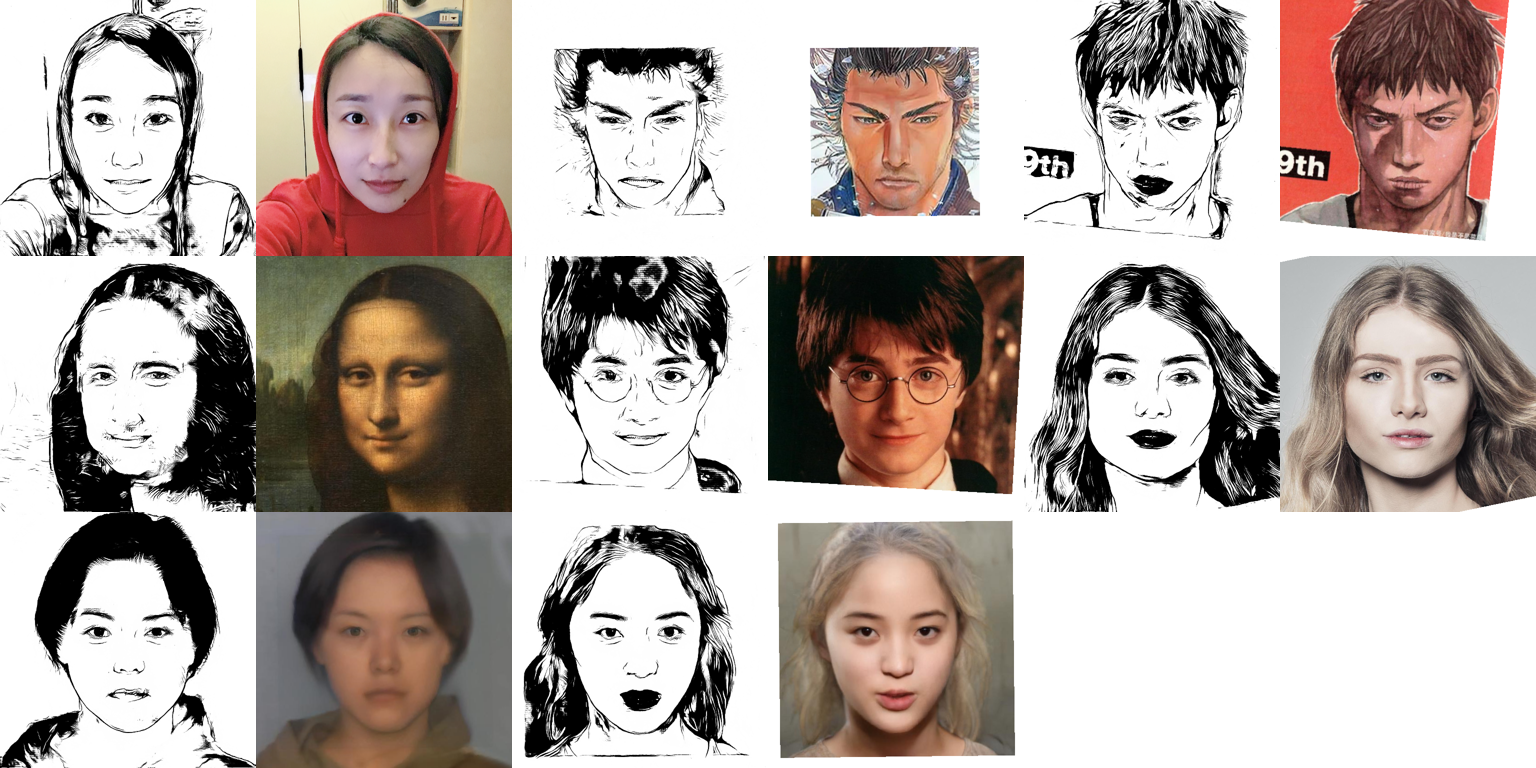

In [81]:
#@title # 显示全部结果与原图
from PIL import Image
import glob
import os
from IPython.display import display


G_img_path = '/content/drive/My Drive/APDrawingGAN2/results/apdrawinggan++_author/test_150/images-single/'
G_img_list = glob.glob(os.path.join(G_img_path, '*.png'))
G_img_list.sort()

begin_x = 0
begin_y = 0

img_num = len(G_img_list)
index_num = int(img_num/6)+1

ALL_Images = Image.new('RGBA', (256 * 6, 256 * index_num))
for i in range(img_num):
  img_path_name = G_img_list[i]
  ALL_Images.paste(Image.open(img_path_name).resize((256,256)), (begin_x, begin_y))
  begin_x += 256
  if begin_x / 1536 == 1:
    begin_x = 0
    begin_y += 256

display(ALL_Images)